In [16]:
import pandas as pd
import numpy as np
import requests
import shelve
import os
from datetime import datetime
import matplotlib.pyplot as plt

Reading CSV file: c:\Users\asus\OneDrive - purdue.edu\VS code\Data\SDUD\SDUD2024.csv
Total rows in 2024 before filtering: 5205065
Rows after removing NA: 2599748
Rows after filtering State='XX': 2362630
Unique NDCs: 33397
Saved 2362630 NDC values to c:\Users\asus\OneDrive - purdue.edu\VS code\Data\ATC\text_files\NDCf_2024.txt
Unique NDC values: 33397
Unique ATC4 Classes: 612
Unique NDCs in ATC4 mapping: 32204
NDCs without ATC4 Class: 1193
NDCs with ATC4 Class: 32204
Saved missing NDCs to c:\Users\asus\OneDrive - purdue.edu\VS code\Data\ATC\text_files\NDC_missing_2024.txt
Using cache: c:\Users\asus\OneDrive - purdue.edu\VS code\Data\ATC\cache_files\atc_names_cache
Reading c:\Users\asus\OneDrive - purdue.edu\VS code\Data\ATC\NDCf_2024_ATC4_classes.csv...
Total rows: 61470
Original columns: ['NDC', 'ATC4 Class']

Creating ATC3 and ATC2 columns from ATC4...
  ATC4 Class ATC3 Class ATC2 Class
0      N01BA       N01B        N01
1      A01AC       A01A        A01
2      A16AX       A16A      

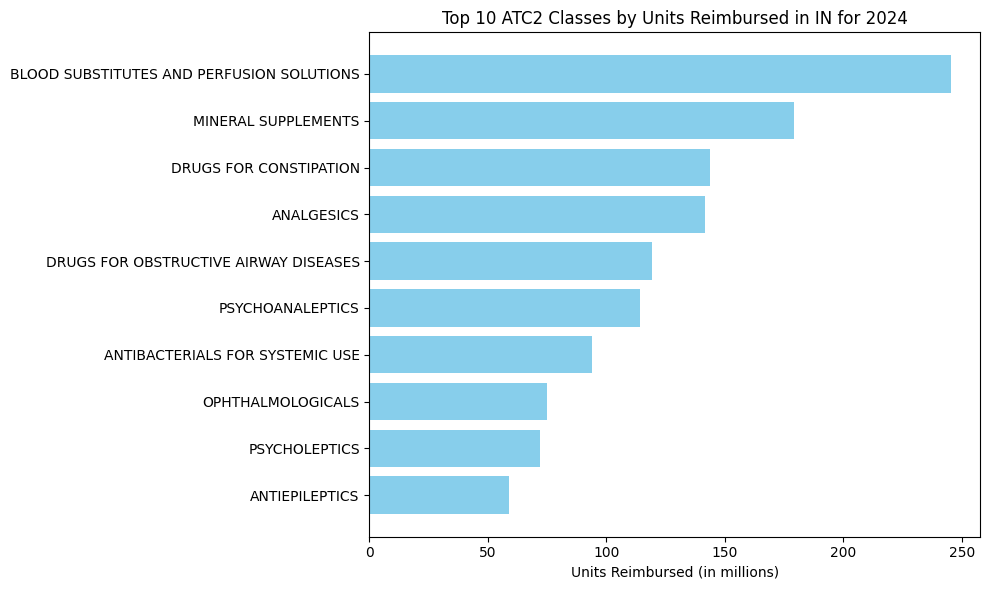

In [23]:
class NDCATCAnalyzer:

    """Analyzes SDUD data and maps NDC codes to ATC classes."""
    
    def __init__(self, year, base_path=None):
        """
        Initialize the analyzer.
        
        Args:
            year: Year of SDUD data to analyze
            base_path: Base directory path (defaults to standard location)
        """
        self.year = year
        if base_path is None:
            #Lookup the user's base path
            self.base_path = r"c:\Users\asus\OneDrive - purdue.edu\VS code\Data"
        else:
            self.base_path = base_path
            
        self.df_cleaned = None
        self.df_merged = None
        self.atc_mapping = None
        
    def clean_sdud_data(self):
        """Step 1: Read and clean SDUD dataset."""
        csv_file = os.path.join(self.base_path, f"SDUD\\SDUD{self.year}.csv")
        print(f"Reading CSV file: {csv_file}")
        
        # Read with NDC as string to preserve leading zeros
        df = pd.read_csv(csv_file, dtype={'NDC': 'object'})
        
        print(f"Total rows in {self.year} before filtering: {len(df)}")
        
        # Remove NA values
        df_filtered = df.dropna(subset=['Units Reimbursed', 'Number of Prescriptions'])
        print(f"Rows after removing NA: {len(df_filtered)}")
        
        # Filter out State='XX'
        df_filtered = df_filtered[df_filtered['State'] != 'XX']
        print(f"Rows after filtering State='XX': {len(df_filtered)}")
        print(f"Unique NDCs: {df_filtered['NDC'].nunique()}")
        
        self.df_cleaned = df_filtered
        return self.df_cleaned
    
    def generate_ndc_txt(self, output_filename=None):
        """Step 2: Generate text file with unique NDC values."""
        if self.df_cleaned is None:
            raise ValueError("Must run clean_sdud_data() first")
            
        if output_filename is None:
            output_filename = f"NDCf_{self.year}.txt"
        
        output_path = os.path.join(self.base_path, f"ATC\\text_files\\{output_filename}")
        
        ndc_values = self.df_cleaned['NDC']
        with open(output_path, 'w') as f:
            for ndc in ndc_values:
                f.write(str(ndc) + '\n')
        
        print(f"Saved {len(ndc_values)} NDC values to {output_path}")
        print(f"Unique NDC values: {ndc_values.nunique()}")
        return output_path
    
    def analyze_atc4_mapping(self):
        """Step 3: Analyze ATC4 mapping results and identify missing NDCs."""
        atc4_path = os.path.join(self.base_path, f"ATC\\NDCf_{self.year}_ATC4_classes.csv")
        
        # Read ATC4 mapping
        df_atc4 = pd.read_csv(atc4_path, dtype={'NDC': 'object'})
        df_atc4['NDC'] = df_atc4['NDC'].str.zfill(11)
        
        print(f"Unique ATC4 Classes: {df_atc4['ATC4 Class'].nunique()}")
        print(f"Unique NDCs in ATC4 mapping: {df_atc4['NDC'].nunique()}")
        
        # Merge with cleaned data
        merged_df = pd.merge(self.df_cleaned, df_atc4, on='NDC', how='left')
        
        # Find missing NDCs
        missing_atc = merged_df[merged_df['ATC4 Class'].isna()]
        missing_ndcs = missing_atc['NDC'].unique()
        
        print(f"NDCs without ATC4 Class: {len(missing_ndcs)}")
        print(f"NDCs with ATC4 Class: {merged_df[merged_df['ATC4 Class'].notna()]['NDC'].nunique()}")
        
        # Save missing NDCs
        missing_file = os.path.join(self.base_path, f"ATC\\text_files\\NDC_missing_{self.year}.txt")
        with open(missing_file, 'w') as f:
            for ndc in missing_ndcs:
                f.write(str(ndc) + '\n')
        print(f"Saved missing NDCs to {missing_file}")
        
        self.atc_mapping = merged_df
        return missing_ndcs
    
    def analyze_atc5_missing(self):
        """Step 3b: Analyze ATC5 results for missing NDCs."""
        miss_path = os.path.join(self.base_path, f"ATC\\NDC_missing_{self.year}_ATC5_classes.csv")
        
        # Check if the file exists first
        if not os.path.exists(miss_path):
            print(f"ATC5 missing file not found: {miss_path}")
            print("This file would be generated by running ATC5 classification on the missing NDCs.")
            return None
            
        df_miss = pd.read_csv(miss_path)
        
        rxcui_no = df_miss[df_miss['ATC5 Class'] == 'No RxCUI Found'].shape[0]
        atc_no = df_miss[df_miss['ATC5 Class'] == 'No ATC Mapping Found'].shape[0]
        
        print(f"NDCs with no RxCUI: {rxcui_no}")
        print(f"NDCs with no ATC mapping: {atc_no}")
        
        return df_miss
    
    def add_atc_names(self, cache_path=None):
        """Step 4-5: Add ATC class names and merge with cleaned data, including missing NDCs with ATC5."""
        if cache_path is None:
            cache_path = os.path.join(self.base_path, "ATC\\cache_files\\atc_names_cache")
        
        atc4_path = os.path.join(self.base_path, f"ATC\\NDCf_{self.year}_ATC4_classes.csv")
        output_path = os.path.join(self.base_path, f"ATC\\ATC4_names{self.year}.csv")
        
        # Use existing function logic for ATC4 mappings
        df_names = self._fetch_atc_names(atc4_path, cache_path)
        df_names.to_csv(output_path, index=False)
        
        # Add missing NDCs with ATC5 classifications (if the file exists)
        atc5_missing_path = os.path.join(self.base_path, f"ATC\\NDC_missing_{self.year}_ATC5_classes.csv")
        
        if os.path.exists(atc5_missing_path):
            print(f"Found ATC5 missing file: {atc5_missing_path}")
            try:
                df_atc5_missing = pd.read_csv(atc5_missing_path, dtype={'NDC': 'object'})
                
                # Create ATC2 and ATC3 from ATC5 for missing NDCs that have valid ATC5
                df_atc5_missing = df_atc5_missing.copy()
                df_atc5_missing['ATC4 Class'] = df_atc5_missing['ATC5 Class']
                
                # Only process NDCs that have valid ATC5 mappings (not "No RxCUI Found" or "No ATC Mapping Found")
                valid_atc5 = df_atc5_missing[
                    (~df_atc5_missing['ATC5 Class'].isin(['No RxCUI Found', 'No ATC Mapping Found'])) &
                    (df_atc5_missing['ATC5 Class'].notna()) &
                    (df_atc5_missing['ATC5 Class'] != '')
                ].copy()
                
                if len(valid_atc5) > 0:
                    # Create ATC levels from ATC5
                    valid_atc5['ATC3 Class'] = valid_atc5['ATC5 Class'].str[:4]
                    valid_atc5['ATC2 Class'] = valid_atc5['ATC5 Class'].str[:3]
                    
                    # Add empty name columns (these will be filled by fetching names)
                    valid_atc5['ATC4_Name'] = ''
                    valid_atc5['ATC3_Name'] = ''
                    valid_atc5['ATC2_Name'] = ''
                    
                    # Reorder columns to match df_names structure
                    valid_atc5 = valid_atc5[['NDC', 'ATC4 Class', 'ATC4_Name', 'ATC3 Class', 'ATC3_Name', 'ATC2 Class', 'ATC2_Name']]
                    
                    # Combine with existing ATC4 mappings
                    df_names_combined = pd.concat([df_names, valid_atc5], ignore_index=True)
                    
                    print(f"Added {len(valid_atc5)} NDCs with valid ATC5 classifications")
                else:
                    df_names_combined = df_names
                    print("No valid ATC5 classifications found to add")
                    
            except Exception as e:
                print(f"Error reading ATC5 missing file: {e}")
                df_names_combined = df_names
        else:
            print(f"ATC5 missing file not found: {atc5_missing_path}")
            print("Proceeding with only ATC4 mappings. To get more coverage:")
            print("1. Use the missing NDCs file to run ATC5 classification")
            print("2. Save results as NDC_missing_{year}_ATC5_classes.csv")
            df_names_combined = df_names
        
        # Merge with cleaned data
        self.df_merged = pd.merge(self.df_cleaned, df_names_combined, on='NDC', how='left')
        
        # Scale units
        self.df_merged['Units Reimbursed'] = self.df_merged['Units Reimbursed'] / 1e6
        self.df_merged['Number of Prescriptions'] = self.df_merged['Number of Prescriptions'] / 1e3
        
        # Report final statistics - Updated mapping coverage calculation
        total_ndcs_cleaned = self.df_cleaned['NDC'].nunique()  # Total unique NDCs in cleaned dataset
        mapped_ndcs = self.df_merged[self.df_merged['ATC4 Class'].notna()]['NDC'].nunique()  # NDCs with ATC4 class
        
        print(f"\nFinal mapping statistics:")
        print(f"Total unique NDCs in cleaned dataset: {total_ndcs_cleaned}")
        print(f"NDCs with ATC4 classification: {mapped_ndcs}")
        print(f"Mapping coverage: {mapped_ndcs/total_ndcs_cleaned*100:.1f}%")
        
        return self.df_merged
    
    def _fetch_atc_names(self, input_file, cache_path):
        """Helper method to fetch ATC names (Step 4 logic)."""
        print(f"Using cache: {cache_path}")
        
        # Read CSV
        print(f"Reading {input_file}...")
        df = pd.read_csv(input_file, dtype={'NDC': 'object'})
        
        print(f"Total rows: {len(df)}")
        print(f"Original columns: {df.columns.tolist()}")
        
        # Create ATC3 and ATC2 columns from ATC4
        print("\nCreating ATC3 and ATC2 columns from ATC4...")
        df['ATC3 Class'] = df['ATC4 Class'].str[:4]
        df['ATC2 Class'] = df['ATC4 Class'].str[:3]
        
        print(df[['ATC4 Class', 'ATC3 Class', 'ATC2 Class']].head(10))
        
        # Add name columns
        df['ATC4_Name'] = ''
        df['ATC3_Name'] = ''
        df['ATC2_Name'] = ''
        
        # Get unique codes for each level
        unique_atc4 = df['ATC4 Class'].dropna().unique()
        unique_atc3 = df['ATC3 Class'].dropna().unique()
        unique_atc2 = df['ATC2 Class'].dropna().unique()
        
        # Filter out invalid codes
        unique_atc4 = [c for c in unique_atc4 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '']]
        unique_atc3 = [c for c in unique_atc3 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '', 'No ', 'No']]
        unique_atc2 = [c for c in unique_atc2 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '', 'No ', 'No']]
        
        print(f"\nUnique codes to fetch:")
        print(f"  ATC4: {len(unique_atc4)}")
        print(f"  ATC3: {len(unique_atc3)}")
        print(f"  ATC2: {len(unique_atc2)}")
        
        total_codes = len(unique_atc4) + len(unique_atc3) + len(unique_atc2)
        
        # Build mappings
        atc4_names = {}
        atc3_names = {}
        atc2_names = {}
        
        with shelve.open(cache_path) as cache:
            start_time = datetime.now()
            processed = 0
            
            # Process ATC4 (without progress printing)
            for code in unique_atc4:
                processed += 1
                atc4_names[code] = self._get_atc_name(code, cache)
            
            # Process ATC3 (without progress printing)
            for code in unique_atc3:
                processed += 1
                atc3_names[code] = self._get_atc_name(code, cache)
            
            # Process ATC2 (without progress printing)
            for code in unique_atc2:
                processed += 1
                atc2_names[code] = self._get_atc_name(code, cache)
            
            print(f"\nTotal processing time: {(datetime.now() - start_time).total_seconds()/60:.1f} minutes")
        
        # Apply mappings to dataframe
        print("\nApplying names to dataframe...")
        df['ATC4_Name'] = df['ATC4 Class'].map(atc4_names).fillna('')
        df['ATC3_Name'] = df['ATC3 Class'].map(atc3_names).fillna('')
        df['ATC2_Name'] = df['ATC2 Class'].map(atc2_names).fillna('')
        
        # Reorder columns to group code and name together
        column_order = ['NDC', 
                        'ATC4 Class', 'ATC4_Name',
                        'ATC3 Class', 'ATC3_Name',
                        'ATC2 Class', 'ATC2_Name']
        df = df[column_order]
        
        print(f"\nComplete! Total rows: {len(df)}")
        print("\nSample output:")
        print(df[['ATC4 Class', 'ATC4_Name', 'ATC3 Class', 'ATC3_Name', 'ATC2 Class', 'ATC2_Name']].head(10))
        
        return df
    
    def _get_atc_name(self, atc_code, cache):
        """Get ATC class name from code, using cache."""
        cache_key = f"atc_name:{atc_code}"
        if cache_key in cache:
            return cache[cache_key]
        
        try:
            url = f"https://rxnav.nlm.nih.gov/REST/rxclass/class/byId.json?classId={atc_code}"
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            
            # Get class name
            if 'rxclassMinConceptList' in data and 'rxclassMinConcept' in data['rxclassMinConceptList']:
                concepts = data['rxclassMinConceptList']['rxclassMinConcept']
                if concepts:
                    name = concepts[0].get('className', '')
                    cache[cache_key] = name
                    return name
            
            cache[cache_key] = ''
            return ''
            
        except Exception as e:
            print(f"Error retrieving name for {atc_code}: {e}")
            cache[cache_key] = ''
            return ''
    
    def rank_top_atc2_by_state(self, top_n=10):
        """Step 6: Rank top ATC2 classes by state."""
        if self.df_merged is None:
            raise ValueError("Must run add_atc_names() first")
        
        # Aggregate by state
        agg_df = self.df_merged.groupby(['State', 'ATC2 Class', 'ATC2_Name']).agg({
            'Units Reimbursed': 'sum',
            'Number of Prescriptions': 'sum'
        }).reset_index()
        
        # Rank by units reimbursed
        agg_df = agg_df.sort_values(['State', 'Units Reimbursed'], ascending=[True, False])
        agg_df['Rank Units Reimbursed'] = agg_df.groupby('State')['Units Reimbursed'].rank(
            method='first', ascending=False
        )
        
        top_10 = agg_df[agg_df['Rank Units Reimbursed'] <= top_n]
        return top_10
    
    def plot_top_atc2(self, state_code, top_n=10):
        """Step 6: Plot top ATC2 classes for a state."""
        if self.df_merged is None:
            raise ValueError("Must run add_atc_names() first")
        
        state_data = self.df_merged[self.df_merged['State'] == state_code]
        state_agg = state_data.groupby(['ATC2 Class', 'ATC2_Name']).agg({
            'Units Reimbursed': 'sum',
            'Number of Prescriptions': 'sum'
        }).reset_index()
        
        state_agg_sorted = state_agg.sort_values('Units Reimbursed', ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 6))
        plt.barh(state_agg_sorted['ATC2_Name'], state_agg_sorted['Units Reimbursed'], color='skyblue')
        plt.xlabel('Units Reimbursed (in millions)')
        plt.title(f'Top {top_n} ATC2 Classes by Units Reimbursed in {state_code} for {self.year}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

# Create analyzer instance
analyzer = NDCATCAnalyzer(year=2024)

# Run the complete workflow
analyzer.clean_sdud_data()
analyzer.generate_ndc_txt()
analyzer.analyze_atc4_mapping()

# This will now work fully - it fetches ATC names and merges with cleaned data
df_merged = analyzer.add_atc_names()

# Continue with analysis
top_rankings = analyzer.rank_top_atc2_by_state()
analyzer.plot_top_atc2('IN')  # Plot for Indiana, for example

In [30]:
# Analyze unmapped NDC codes - units reimbursed and prescriptions
print(f"=== Analysis of Unmapped NDC Codes for {analyzer.year} ===")

# Filter for unmapped NDCs (those without ATC classifications)
unmapped_ndcs = df_merged[df_merged['ATC2 Class'].isna()]

# Calculate totals for unmapped NDCs
unmapped_units = unmapped_ndcs['Units Reimbursed'].sum()
unmapped_prescriptions = unmapped_ndcs['Number of Prescriptions'].sum()
unmapped_unique_ndcs = unmapped_ndcs['NDC'].nunique()

print(f"Unmapped NDCs Summary:")
print(f"- Unique unmapped NDCs: {unmapped_unique_ndcs:,}")
print(f"- Total units reimbursed: {unmapped_units:.1f} million")
print(f"- Total prescriptions: {unmapped_prescriptions:.1f} thousand")

# Calculate totals from the cleaned dataset (scaled to match df_merged units)
if analyzer.df_cleaned is None:
    analyzer.clean_sdud_data()

total_units = analyzer.df_cleaned['Units Reimbursed'].sum() / 1e6  # millions
print(f"\nTotal units reimbursed in cleaned dataset: {total_units:.1f} million")

total_prescriptions = analyzer.df_cleaned['Number of Prescriptions'].sum() / 1e3  # thousands
print(f"Total prescriptions in cleaned dataset: {total_prescriptions:.1f} thousand")

print(f"\nPercentage of total:")
print(f"- Units reimbursed: {unmapped_units/total_units*100:.1f}%")
print(f"- Number of prescriptions: {unmapped_prescriptions/total_prescriptions*100:.1f}%")

# Top unmapped NDCs by units reimbursed
print(f"\nTop 10 unmapped NDCs by units reimbursed:")
top_unmapped = unmapped_ndcs.groupby('NDC').agg({
    'Units Reimbursed': 'sum',
    'Number of Prescriptions': 'sum'
}).sort_values('Units Reimbursed', ascending=False).head(10)
print(top_unmapped)

# Unmapped NDCs by state
print(f"\nUnmapped NDCs impact by state:")
state_unmapped = unmapped_ndcs.groupby('State').agg({
    'Units Reimbursed': 'sum',
    'Number of Prescriptions': 'sum',
    'NDC': 'nunique'
}).round(1)
state_unmapped.columns = ['Unmapped Units (millions)', 'Unmapped Prescriptions (thousands)', 'Unique Unmapped NDCs']
state_unmapped = state_unmapped.sort_values('Unmapped Units (millions)', ascending=False).head(10)
print(state_unmapped)

=== Analysis of Unmapped NDC Codes for 2024 ===
Unmapped NDCs Summary:
- Unique unmapped NDCs: 1,193
- Total units reimbursed: 527.6 million
- Total prescriptions: 4750.5 thousand

Total units reimbursed in cleaned dataset: 46336.0 million
Total prescriptions in cleaned dataset: 729425.6 thousand

Percentage of total:
- Units reimbursed: 1.1%
- Number of prescriptions: 0.7%

Top 10 unmapped NDCs by units reimbursed:
             Units Reimbursed  Number of Prescriptions
NDC                                                   
00338001329         59.961973                   15.532
63323082010         31.416468                   25.911
00338001308         27.492273                    9.747
00338001306         26.458618                   19.724
00338001304         25.059360                   22.888
00407141491         18.952170                  212.643
24385009647         17.316294                   13.887
00264738560         14.456365                    4.609
63323082005         14.314660 